<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook is for the process of fine-tuning the MedSAM Model (Segment Anything in Medical Images) using our custom dataset**.
<p>


**MedSAM paper:** https://arxiv.org/pdf/2304.12306​
**<br>SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​

**MedSAM repository:** https://github.com/bowang-lab/MedSAM
**<br>MedSAM model in Hugging Face:** https://huggingface.co/flaviagiammarino/medsam-vit-base
<p>

**Link to the dataset used in this process:** https://drive.google.com/file/d/1m7tMpE9qEcQGQjL_BdMD-Mvgmc44hG1Y/view?usp=drive_link
**<p>Data description**
<br>Image type: 3D (CT Images); Format: NifTI (.nii.gz)
<br>Height: 512px; Width: 512px; Depth: not fixed

This code has taken referance from these notebooks but completely modified to work for our custom dataset.
<br>https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb
<br>https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb
<p>

##### Install the required libraries

In [1]:
#SAM
#!pip install git+https://github.com/facebookresearch/segment-anything.git
#MEDSAM
!pip install git+https://github.com/bowang-lab/MedSAM.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3pvhcrte
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3pvhcrte
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/bowang-lab/MedSAM.git to /tmp/pip-req-build-l6vz58ps
  Running command git clone --filter=blob:none --quiet https://github.com/bowang-lab/MedSAM.git /tmp/pip-req-build-l6vz58ps
  Resolved https://github.com/bowang-lab/MedSAM.git to commit c6dcd24ce143d861772740dc6b106dff0b79ad6d
  Preparing metadata (setup.py) ... done


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from patchify import patchify  #Only to handle large images
import random
import nibabel as nib
from glob import glob
#import cv2
from torch.utils.data import Dataset
from datasets import Dataset
from PIL import Image

## Data Loading and Data Generation

##### Load data into numpy arrays. Here we are importing 3D CT images and corresponding masks in .nii.gz format. We use glob to import multiple images from a directory. The goal is to end up with a numpy array for images and an array for masks.

In [2]:
def load_nii_file(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data

def load_data_3d(images_path, masks_path):
    images = []
    masks = []

    image_files = sorted(glob(images_path))
    mask_files = sorted(glob(masks_path))

    for img_path, mask_path in zip(image_files, mask_files):
        img_data = load_nii_file(img_path)
        mask_data = load_nii_file(mask_path)

        for i in range(img_data.shape[2]):  # Iterate over the slices
            img_slice = img_data[:, :, i]
            mask_slice = mask_data[:, :, i]
            
            images.append(img_slice)
            masks.append(mask_slice)
        
    return np.array(images), np.array(masks)

In [3]:
# Define paths to your images and masks directories
images_path = '../Colon/imagesTr/*.nii.gz'
masks_path = '../Colon/labelsTr/*.nii.gz'

# Load the data
large_images, large_masks = load_data_3d(images_path, masks_path)

In [4]:
print(large_images.shape)
print(large_masks.shape)

(11855, 512, 512)
(11855, 512, 512)


All images and masks are loaded and converted to numpy array.

##### Now, let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [5]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [6]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img).astype(np.uint8)
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            if single_patch_mask.max() <= 1:
                single_patch_mask = (single_patch_mask * 255) # Multiply by 255 if the mask is in [0, 1]
            single_patch_mask = (single_patch_mask).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [7]:
print(images.shape)
print(masks.shape)

(47420, 256, 256)
(47420, 256, 256)


##### Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [8]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.any()]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1707, 256, 256)
Mask shape: (1707, 256, 256)


##### Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [9]:
# Convert to RGB and ensure the data type is uint8
def convert_img(image):
    # Ensure the data type is uint8 and the range is [0, 255]
    if image.ndim == 2:  # If the image is grayscale, convert to RGB
        # Convert BGR and RGB with Python – OpenCV
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # Otherwise stack one extra channel (Both will give same result)
        image = np.stack((image,) * 3, axis=-1)
    return image

In [10]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(convert_img(img)) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [11]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1707
})

##### Let us make sure out images and masks (labels) are loading appropriately

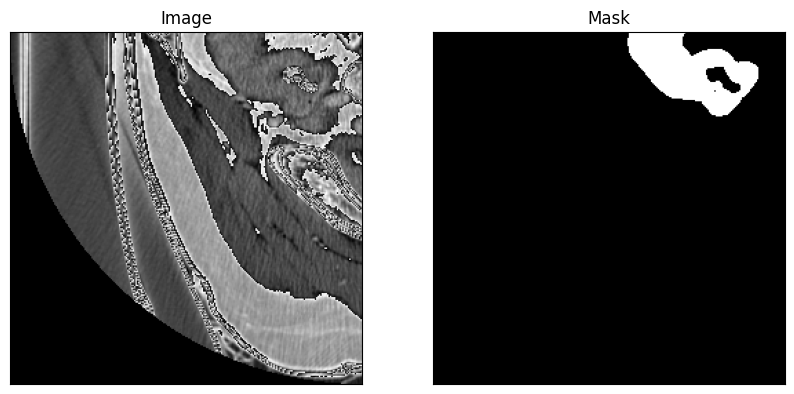

In [13]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## Fine-tuning Process

In [14]:
from transformers import SamProcessor
from torch.utils.data import DataLoader
from transformers import SamModel
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

Function to get bounding boxes from masks.

In [15]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [16]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [17]:
# Initialize the processor
#processor = SamProcessor.from_pretrained("facebook/sam-vit-base") # Loading SAM
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base") # Loading MedSAM

In [18]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [19]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [20]:
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [21]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [22]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [23]:
# Load the model
#model = SamModel.from_pretrained("facebook/sam-vit-base") # Loading SAM
model = SamModel.from_pretrained("wanglab/medsam-vit-base") # Loading MedSAM

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [24]:
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
#Training loop
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

##### Save the model's state dictionary to a file

In [29]:
torch.save(model.state_dict(), "sam_ft_model_100eps/MEDSAM/colcan_model_checkpoint.pth")